## Mitsiu Alejandro Carreño Sarabia - E23S-18014
 En el cuaderno quizá pudiste notar que algunas de las selecciones contenían parámetros.
           
Investiga cuales son estos parámetros, que significan para que sirven y si afecta los ejemplos que vimos. Presenta el parámetro cambiado, su valor y los resultados obtenidos de este cambio. Explica el razonamiento del cambio      


Los siguiente son ejemplos de parámetros:
* learning_rate para el optimizador Adam
* mean para el inicializador random normal
* rate para la capa dropout
* l1 y l2 para los regularizadores l1, l2 y l1l2


In [1]:
import numpy as np
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt


2023-10-08 22:57:45.995229: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 22:57:46.683092: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-08 22:57:46.687397: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 22:57:49.997670: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Carga de datos
digits = datasets.load_digits()
X_train, X_test, y_train, y_test = train_test_split(digits.data, digits.target, test_size=0.2, random_state=42)
#Escalar datos
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


## Evaluación de inicializadores

In [3]:
from tensorflow import initializers

In [4]:
modelos = dict()
inicializadores = {
    "Default": initializers.RandomNormal(seed=2023),
    "mean 10": initializers.RandomNormal(seed=2023, mean=10),
    "mean 100": initializers.RandomNormal(seed=2023, mean=100),
    "stddev 10": initializers.RandomNormal(seed=2023, stddev=10),
    "stddev 100": initializers.RandomNormal(seed=2023, stddev=100),
    "mean 10 stddev 10": initializers.RandomNormal(seed=2023, mean=10, stddev=10),
}

for inicializador in inicializadores:
    model = keras.Sequential([
        keras.layers.Input(shape=(64,)),
        keras.layers.Dense(128, activation='relu', kernel_initializer = inicializadores[inicializador]),
        keras.layers.Dense(10, activation='softmax', kernel_initializer = inicializadores[inicializador])
    ])
    
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    
    print(inicializador)
    modelos[inicializador] = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=0)

Default
mean 10
mean 100
stddev 10
stddev 100
mean 10 stddev 10


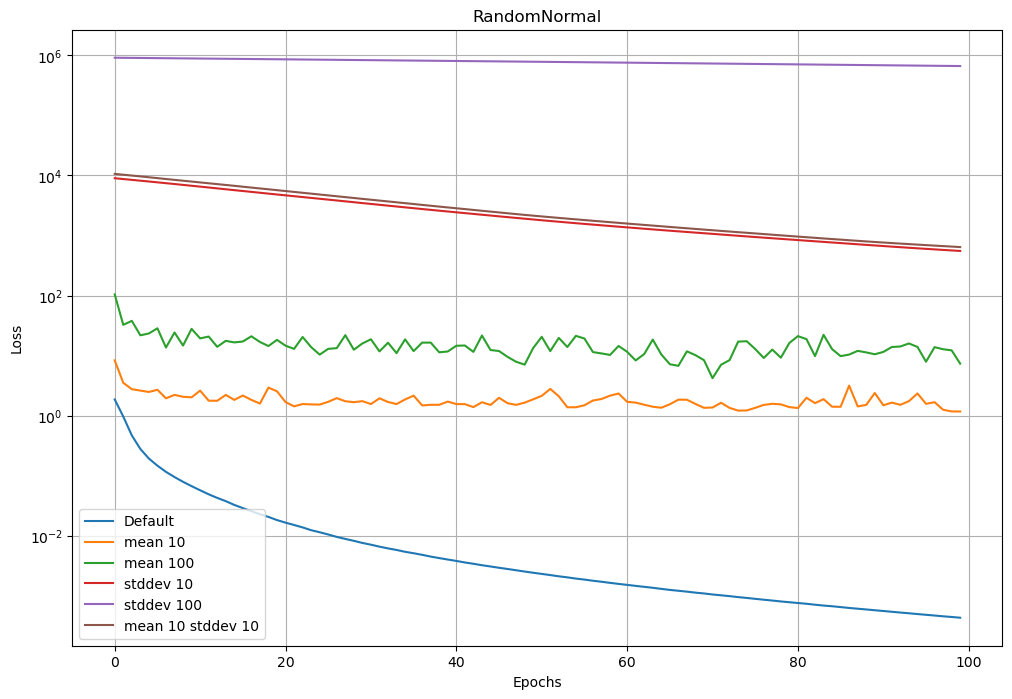

In [5]:
plt.figure(figsize=(12,8))
for llave in modelos:
    plt.semilogy(modelos[llave].history["loss"], label=llave)
    
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RandomNormal")
plt.legend()
plt.grid(True)

Durante esta comparación se corrió el mismo modelo con 6 valores iniciales de pesos, variando el valor de mean (promedio de los valores de inicialización) y stddev (desviación estandar de los valores de inicialización), podemos observar que la mejor inicialización fue con los valores por default y esto hace sentido ya que nuestros datos fueron preprocesados con una desviación estandar de uno, reduciendo la diferencia entre escalas grandes y pequeñas de nuestros features analizados.      
           
Aumentar el valor mean afecta la convergencia ya que nuestros pesos iniciales tienden a ser muy grandes comparados con los valores sobre los que acutan, pero aumentar el stddev ralentiza considerablemente la capacidad de convergencia del modelo.            

# Evaluación de Dropout

In [6]:
X, y = datasets.make_moons(n_samples=200, noise=0.3, random_state=123)

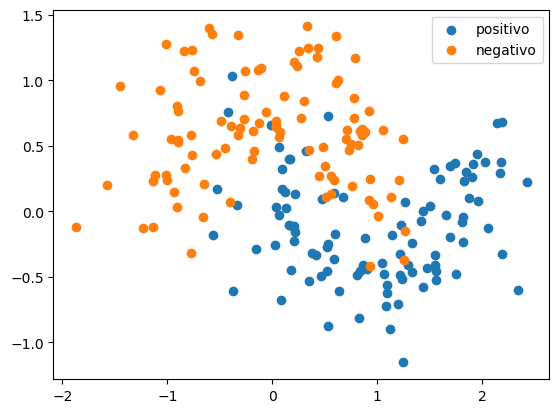

In [7]:
plt.scatter(X[y==1,0], X[y==1,1], label="positivo")
plt.scatter(X[y==0,0], X[y==0,1], label="negativo")
plt.legend()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [9]:
modelos = dict()
dropouts = {
    "0.1": keras.layers.Dropout(0.1),
    "0.4": keras.layers.Dropout(0.4),
    "0.9": keras.layers.Dropout(0.9),
    "0.999": keras.layers.Dropout(0.999),
}

for drop in dropouts:
    
    modelo_drop = keras.Sequential()
    modelo_drop.add(keras.layers.Dense(500, input_dim=2, activation="relu"))
    modelo_drop.add(dropouts[drop])
    modelo_drop.add(keras.layers.Dense(1, activation="sigmoid"))
    
    modelo_drop.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    print(drop)
    modelos[drop] = modelo_drop.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, verbose=0)

0.1
0.4
0.9
0.999


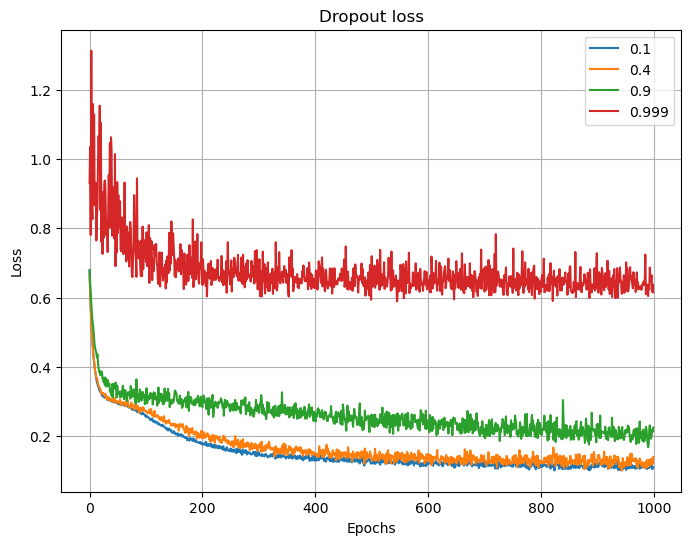

In [10]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

for llave in modelos:
    plt.plot(modelos[llave].history["loss"], label=llave)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Dropout loss')
plt.legend()

plt.grid(True)

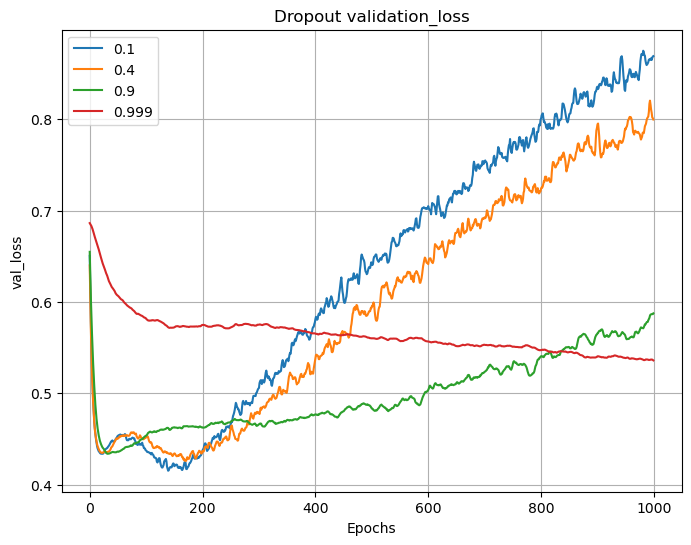

In [11]:
plt.figure(figsize=(8, 6))  # Adjust the figure size

for llave in modelos:
    plt.plot(modelos[llave].history["val_loss"], label=llave)

plt.xlabel('Epochs')
plt.ylabel('val_loss')
plt.title('Dropout validation_loss')
plt.legend()

plt.grid(True)

Modificando la capa de dropout y gráficando la perdida (loss) podemos notar que en general los valores pequeños nos ofrecen mejores resultados, con decenso de perdida más rápidos y estables, y a medida que aumenta la cantidad de neuronas ignoradas los resultados tienden a ser más variables entre sus epochs consiguientes, teniendo un dropout muy grande (99.9%) la habilidad del modelo de ajustarse es casí nula porque casí toda la información de los datos de entrada queda suprimida.      
                       
En cambio nuestra medición de la perdida de validación (validation_loss) nos muestra que valores de (10% y 40%) tienden a sobreentrenar la red pasados los 200 epochs y terminando los 600 epochs tienen incluso peores resultados que los valores iniciales.                

## Evaluación de Regularizadores

In [12]:
modelos = dict()
regularizers = {
    "L1 0.1": keras.regularizers.L1(0.1),
    "L1 0.001": keras.regularizers.L1(0.001),
    "L1 0.000000001": keras.regularizers.L1( 0.000000001),
    "L2 0.1": keras.regularizers.L2(0.1),
    "L2 0.001": keras.regularizers.L2(0.001),
    "L2 0.000000001": keras.regularizers.L2( 0.000000001),
    "L1L2 0.1": keras.regularizers.L1L2(0.1),
    "L1L2 0.001": keras.regularizers.L1L2(0.001),
    "L1L2 0.000000001": keras.regularizers.L1L2( 0.000000001),
}

for regul in regularizers:
    modelo = keras.Sequential()
    modelo.add(keras.layers.Dense(
        500, 
        input_dim=2, 
        activation="relu", 
        kernel_regularizer=regularizers[regul],
        bias_regularizer=regularizers[regul]
    ))
    modelo.add(keras.layers.Dense(
        1, 
        activation="sigmoid", 
        kernel_regularizer=regularizers[regul],
        bias_regularizer= regularizers[regul]
    ))
    
    modelo.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    print(regul)
    modelos[regul] = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=1000, verbose=0)

L1 0.1
L1 0.001
L1 0.000000001
L2 0.1
L2 0.001
L2 0.000000001
L1L2 0.1
L1L2 0.001
L1L2 0.000000001


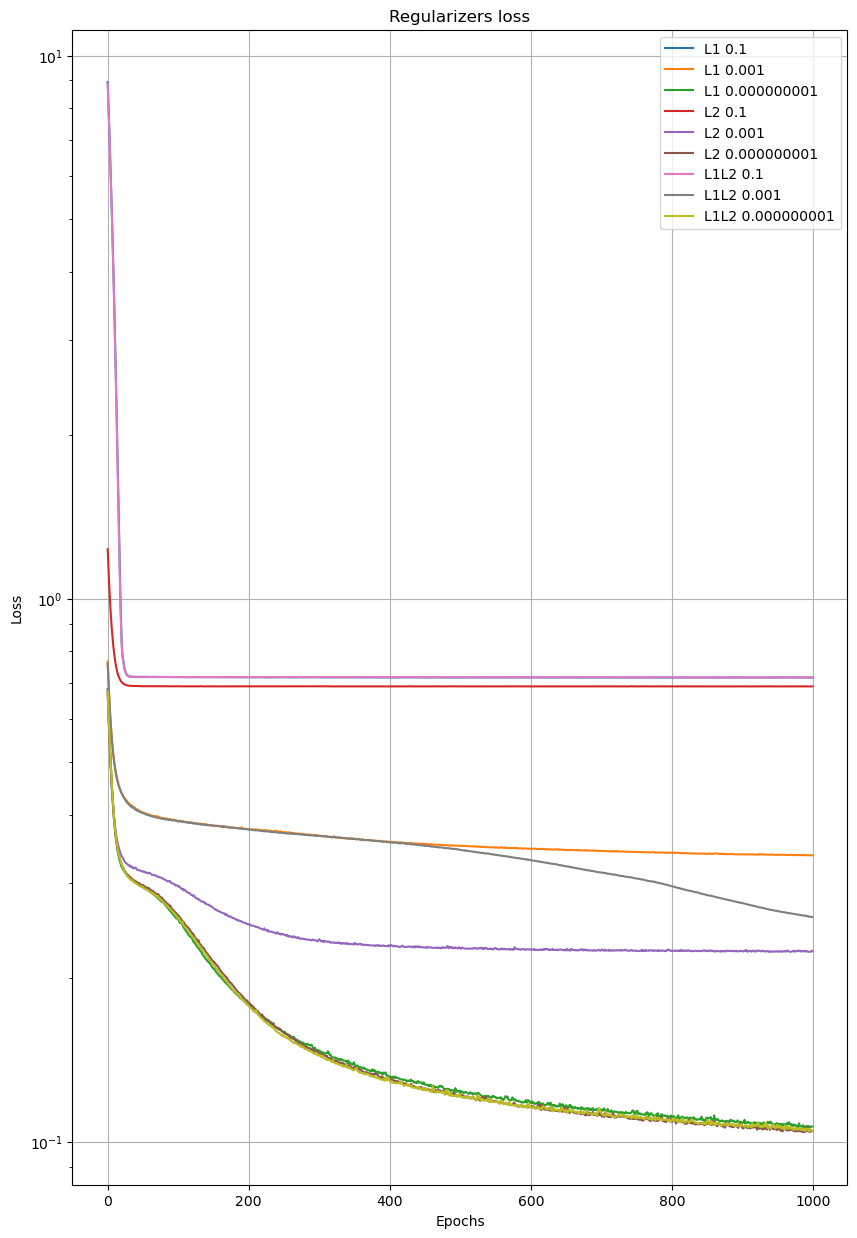

In [16]:
plt.figure(figsize=(10, 15))  # Adjust the figure size

for llave in modelos:
    plt.semilogy(modelos[llave].history["loss"], label=llave)

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Regularizers loss')
plt.legend()

plt.grid(True)

Finalmente se evaluaron tres valores para regularización L1, L2 y L1L2 con valores decrementales.      
Aunque es un poco dificil de apreciar de manera generalizada la líneas que más logran disminuír el error son las que tienen un valor más pequeño en el regularizador, esto principalmente se debe a que los regularizadores  L1 y L2 emplean la formula $$loss = l1 *reduce\_sum(abs(x))$$ y $$loss = l2 * reduce\_sum(square(x))$$ cabe resaltar que estos regularizadores actuan sobre los valores de los pesos así como los bias, dichos valores queremos queremos que se mantengan pequeños para no sobreentrenar la red, por ello aplicar una penalización pequeña nos permite mejorar el desempeño de la red.          